# Importing the required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Reading the ratings and movies dataset files.
ratings = pd.read_csv("ratings.csv", encoding='latin-1')
movies = pd.read_csv('movies.csv')

In [3]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


# Exploratory Data Analysis

In [5]:
no_rating = len(ratings)
no_movies = ratings['movieId'].nunique()
no_users = ratings['userId'].nunique()

print(f"Number of ratings: {no_rating}")
print(f"Number of unique movies: {no_movies}")
print(f"Number of unique users: {no_users}")
print(f"Average number of ratings per user: {round(no_rating/no_users, 2)}")
print(f"Average number of ratings per movie: {round(no_rating/no_movies, 2)}")

Number of ratings: 100836
Number of unique movies: 9724
Number of unique users: 610
Average number of ratings per user: 165.3
Average number of ratings per movie: 10.37


## Distribution of movie rating

Text(0, 0.5, 'Frequency')

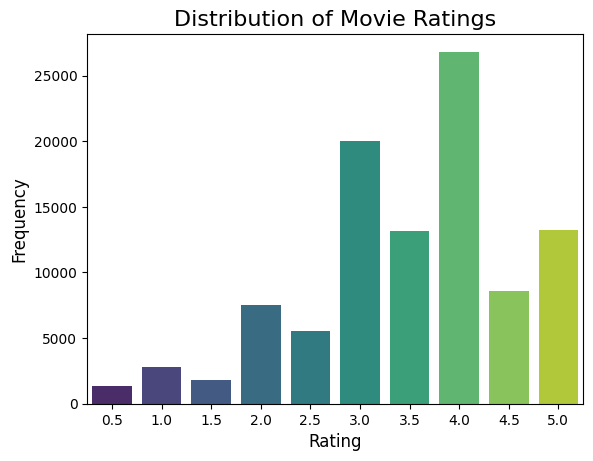

In [6]:
sns.countplot(data=ratings, x = 'rating', hue=None, palette="viridis", legend=False)
plt.title("Distribution of Movie Ratings", fontsize=16)
plt.xlabel("Rating", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

In [7]:
print(f"Mean global rating: {round(ratings['rating'].mean(),2)}.")

mean_ratings = ratings.groupby('userId')['rating'].mean()
print(f"Mean rating per user: {round(mean_ratings.mean(),2)}.")

Mean global rating: 3.5.
Mean rating per user: 3.66.


## Movies with most ratings

In [8]:
movie_ratings = ratings.merge(movies[['movieId', 'title']], on='movieId', how='left')
movie_ratings['title'].value_counts()[0:10]

title
Forrest Gump (1994)                          329
Shawshank Redemption, The (1994)             317
Pulp Fiction (1994)                          307
Silence of the Lambs, The (1991)             279
Matrix, The (1999)                           278
Star Wars: Episode IV - A New Hope (1977)    251
Jurassic Park (1993)                         238
Braveheart (1995)                            237
Terminator 2: Judgment Day (1991)            224
Schindler's List (1993)                      220
Name: count, dtype: int64

- Forrest Gump has the most number of ratings, with 329 ratings.
***

## Highest and Lowest Rated Movies

Calculating the highest and lowest rated movies directly based on the ratings they have is not appropriate. Some movies may have high rating but they might be reviewed by small number of unique reviewers and might not represent the sentiment of the overall general population. As we can see __"Andrew Dice Clay: Dice Rules (1991)"__ has a rating of 4 but only has 1 review.

In [9]:
movie_ratings_info = (
    ratings.groupby('movieId')
    .agg(
        num_ratings=('rating', 'size'),
        avg_rating=('rating', 'mean')
    )
    .reset_index()
    .merge(movies[['movieId', 'title']], on='movieId', how='left')
    .sort_values(by='num_ratings', ascending=False)
)
movie_ratings_info['avg_rating'] = movie_ratings_info['avg_rating'].round(2)

print(movie_ratings_info)

      movieId  num_ratings  avg_rating                                   title
314       356          329        4.16                     Forrest Gump (1994)
277       318          317        4.43        Shawshank Redemption, The (1994)
257       296          307        4.20                     Pulp Fiction (1994)
510       593          279        4.16        Silence of the Lambs, The (1991)
1938     2571          278        4.19                      Matrix, The (1999)
...       ...          ...         ...                                     ...
3053     4093            1        1.50                              Cop (1988)
3049     4089            1        2.00                Born in East L.A. (1987)
6687    58351            1        4.00  City of Men (Cidade dos Homens) (2007)
3045     4083            1        4.00                      Best Seller (1987)
9723   193609            1        4.00     Andrew Dice Clay: Dice Rules (1991)

[9724 rows x 4 columns]


***
Therefore a better approach would be using Bayesisan Average to to evaluate the movie popularity.
Bayesian Average is defined as:

$
r_i = \frac{C \cdot m + \sum{reviews}}{C + N}
$

Where:
- C represents our confidence,
- m represents our prior, and
- Nis the total number of reviews for movie i.
- In this case, our prior m will be the average mean rating across all movies.
- By defintion, C represents "the typical data set size". Let's make C be the average number of ratings for a given movie.
***


In [10]:
movie_overview = ratings.groupby('movieId')['rating'].agg(['count', 'mean'])
movie_overview.head()

,count,mean
movieId,,
1,215,3.920930
2,110,3.431818
3,52,3.259615
4,7,2.357143
5,49,3.071429


In [11]:
C = movie_overview['count'].mean() # Average number of ratings per movie
m = movie_overview['mean'].mean() # Global average rating

print(f"Average number of ratings for a given movie: {C: .2f}")
print(f"Average rating for a given movie: {m: .2f}")

def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return round(bayesian_avg, 3)

Average number of ratings for a given movie:  10.37
Average rating for a given movie:  3.26


In [12]:
bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
movie_overview = movie_overview.merge(bayesian_avg_ratings, on='movieId')

In [13]:
movie_overview = movie_overview.merge(movies[['movieId', 'title']])
movie_overview.sort_values('bayesian_avg', ascending=False).head()

,movieId,count,mean,bayesian_avg,title
277,318,317,4.429022,4.392,"Shawshank Redemption, The (1994)"
659,858,192,4.289062,4.236,"Godfather, The (1972)"
2224,2959,218,4.272936,4.227,Fight Club (1999)
224,260,251,4.231076,4.193,Star Wars: Episode IV - A New Hope (1977)
46,50,204,4.237745,4.191,"Usual Suspects, The (1995)"


Using the Bayesian average, we see that __Shawshank Redemption__, __The Godfather__, and __The Usual Suspects__ are the most highly rated movies. This result makes much more sense since these movies are critically acclaimed films.
***

In [14]:
movie_overview.sort_values('bayesian_avg', ascending=True).head()

,movieId,count,mean,bayesian_avg,title
1172,1556,19,1.605263,2.190,Speed 2: Cruise Control (1997)
2679,3593,19,1.657895,2.224,Battlefield Earth (2000)
1372,1882,33,1.954545,2.267,Godzilla (1998)
1144,1499,27,1.925926,2.297,Anaconda (1997)
1988,2643,16,1.687500,2.307,Superman IV: The Quest for Peace (1987)


With Bayesian averaging, it looks like __Speed 2: Cruise Control__, __Battlefield Earth__, and __Godzilla__ are the worst rated movies.
***

## Analysing Movie genres

In [15]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


***
The movies dataset needs to be cleaned in two ways:
- `genres` is expressed as a string with a pipe ` | ` separating each genre. We will manipulate this string into a list, which will make it much easier to analyze.
- `title` currently has (year) appended at the end. We will extract year from each title string and create a new column for it.
***

In [16]:
movies['genres'] = movies['genres'].apply(lambda x: x.split("|"))
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [17]:
from collections import Counter

genre_frequency = Counter(g for genres in movies['genres'] for g in genres)

print(f"There are {len(genre_frequency)} genres.")

genre_frequency

There are 20 genres.


Counter({'Drama': 4361,
         'Comedy': 3756,
         'Thriller': 1894,
         'Action': 1828,
         'Romance': 1596,
         'Adventure': 1263,
         'Crime': 1199,
         'Sci-Fi': 980,
         'Horror': 978,
         'Fantasy': 779,
         'Children': 664,
         'Animation': 611,
         'Mystery': 573,
         'Documentary': 440,
         'War': 382,
         'Musical': 334,
         'Western': 167,
         'IMAX': 158,
         'Film-Noir': 87,
         '(no genres listed)': 34})

In [18]:
print("The 5 most common genres: \n", genre_frequency.most_common(5))

The 5 most common genres: 
 [('Drama', 4361), ('Comedy', 3756), ('Thriller', 1894), ('Action', 1828), ('Romance', 1596)]


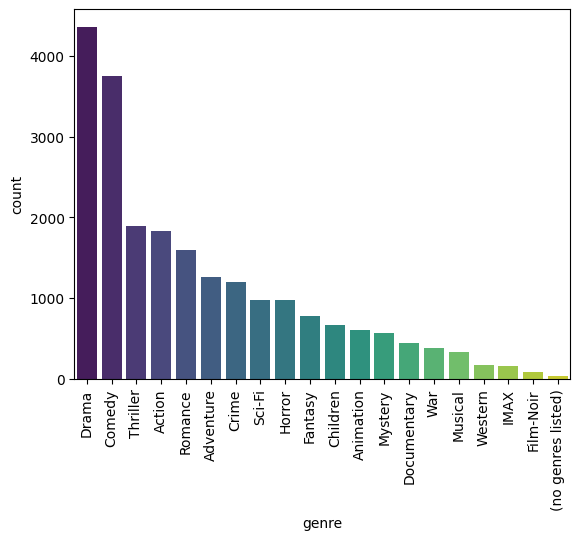

In [19]:
genre_frequency_df = pd.DataFrame([genre_frequency]).T.reset_index()
genre_frequency_df.columns = ['genre', 'count']

sns.barplot(x='genre', y='count', palette="viridis",data=genre_frequency_df.sort_values(by='count', ascending=False))
plt.xticks(rotation=90)
plt.show()

# Divide Data

In [20]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(ratings, test_size=0.30, random_state = 31)

In [21]:
print(train.shape)
print(test.shape)

(70585, 4)
(30251, 4)


In [22]:
df_movie_features = train.pivot(
    index='userId',
    columns='movieId',
    values='rating'
).fillna(0)

In [23]:
df_movie_features.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,190215,190219,190221,191005,193565,193567,193571,193579,193583,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


***
These dataset will be used for prediction and evaluation.
- Dummy train will be used later for prediction of the movies which has not been rated by the user. To ignore the movies rated by the user, we will mark it as 0 during prediction. The movies not rated by user is marked as 1 for prediction.
- Dummy test will be used for evaluation. To evaluate, we will only make prediction on the movies rated by the user. So, this is marked as 1. This is just opposite of dummy_train
***

In [24]:
dummy_train = train.copy()
dummy_test = test.copy()

In [25]:
dummy_train['rating'] = dummy_train['rating'].apply(lambda x: 0 if x>=1 else 1)
dummy_test['rating'] = dummy_test['rating'].apply(lambda x: 0 if x>=1 else 1)

In [26]:
dummy_train = dummy_train.pivot(
    index='userId',
    columns='movieId',
    values='rating'
).fillna(1)

dummy_test = dummy_test.pivot(
    index='userId',
    columns='movieId',
    values='rating'
).fillna(0)

In [27]:
dummy_train.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,190215,190219,190221,191005,193565,193567,193571,193579,193583,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [28]:
dummy_test.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,187595,188189,188797,188833,189111,190209,193573,193581,193585,193587
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# User Based

## Cosine Similarity

In [29]:
from sklearn.metrics.pairwise import pairwise_distances

user_correlation = 1 - pairwise_distances(df_movie_features, metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[1.         0.03844192 0.08536622 ... 0.19408656 0.06817714 0.08887333]
 [0.03844192 1.         0.         ... 0.0422197  0.         0.0883011 ]
 [0.08536622 0.         1.         ... 0.01647758 0.         0.02845466]
 ...
 [0.19408656 0.0422197  0.01647758 ... 1.         0.07774534 0.21316911]
 [0.06817714 0.         0.         ... 0.07774534 1.         0.04861171]
 [0.08887333 0.0883011  0.02845466 ... 0.21316911 0.04861171 1.        ]]


In [30]:
user_correlation.shape

(610, 610)

## Adjusted Cosine Similarity

In [31]:
movie_features = train.pivot(
    index='userId',
    columns='movieId',
    values='rating'
)

In [32]:
movie_features.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,190215,190219,190221,191005,193565,193567,193571,193579,193583,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
# Normalising the rating of the movie for each user aroung 0 mean
mean = np.nanmean(movie_features, axis=1)
df_subtracted = (movie_features.T-mean).T

In [34]:
df_subtracted.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,190215,190219,190221,191005,193565,193567,193571,193579,193583,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,-0.35,NaN,-0.35,NaN,NaN,-0.35,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
# Finding cosine similarity
from sklearn.metrics.pairwise import pairwise_distances

# User Similarity Matrix
user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[ 1.          0.00694602  0.00160449 ...  0.08373762 -0.03376757
   0.01625135]
 [ 0.00694602  1.          0.         ...  0.00263096  0.
   0.02505163]
 [ 0.00160449  0.          1.         ... -0.00666446  0.
   0.02409337]
 ...
 [ 0.08373762  0.00263096 -0.00666446 ...  1.          0.02601342
   0.03271935]
 [-0.03376757  0.          0.         ...  0.02601342  1.
  -0.04036397]
 [ 0.01625135  0.02505163  0.02409337 ...  0.03271935 -0.04036397
   1.        ]]


### Prediction
Doing the prediction for the users which are positively related with other users, and not the users which are negatively related as we are interested in the users which are more similar to the current users. So, ignoring the correlation for values less than 0. 

In [36]:
user_correlation[user_correlation<0] = 0
user_correlation

array([[1.        , 0.00694602, 0.00160449, ..., 0.08373762, 0.        ,
        0.01625135],
       [0.00694602, 1.        , 0.        , ..., 0.00263096, 0.        ,
        0.02505163],
       [0.00160449, 0.        , 1.        , ..., 0.        , 0.        ,
        0.02409337],
       ...,
       [0.08373762, 0.00263096, 0.        , ..., 1.        , 0.02601342,
        0.03271935],
       [0.        , 0.        , 0.        , ..., 0.02601342, 1.        ,
        0.        ],
       [0.01625135, 0.02505163, 0.02409337, ..., 0.03271935, 0.        ,
        1.        ]])

In [37]:
user_predicted_ratings = np.dot(user_correlation, movie_features.fillna(0))
user_predicted_ratings

array([[1.58446164e+01, 5.54354123e+00, 7.08245905e+00, ...,
        0.00000000e+00, 0.00000000e+00, 2.80275213e-02],
       [5.07686451e+00, 2.06757205e+00, 6.00874556e-01, ...,
        1.81453987e-02, 1.81453987e-02, 0.00000000e+00],
       [2.24241909e+00, 1.17788776e+00, 2.90450622e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.90584218e+01, 1.02243416e+01, 6.91134419e+00, ...,
        2.06953826e-02, 2.06953826e-02, 3.14163689e-02],
       [1.90831554e+01, 8.84849001e+00, 4.23018218e+00, ...,
        0.00000000e+00, 0.00000000e+00, 8.24765355e-02],
       [2.68340188e+01, 1.02826443e+01, 4.23972094e+00, ...,
        1.25133258e-01, 1.25133258e-01, 5.45579834e-01]])

In [38]:
user_predicted_ratings.shape

(610, 8536)

In [39]:
user_final_rating = np.multiply(user_predicted_ratings, dummy_train)
user_final_rating.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,190215,190219,190221,191005,193565,193567,193571,193579,193583,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,0.000000,5.543541,0.000000,0.094025,1.916126,0.000000,2.631891,0.341030,0.247799,6.278434,...,0.023942,0.015961,0.015961,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.028028
2,5.076865,2.067572,0.600875,0.031692,0.584751,1.731990,0.393717,0.090132,0.048347,1.573140,...,0.000000,0.000000,0.000000,0.02333,0.018145,0.015553,0.020738,0.018145,0.018145,0.000000
3,2.242419,1.177888,0.290451,0.013938,0.123168,1.608382,0.156013,0.027674,0.019174,1.574436,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,7.362739,3.797650,2.323971,0.178680,1.499134,3.662610,2.192954,0.074205,0.360735,3.787689,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,8.908434,3.050563,0.389251,3.424406,7.754833,4.715943,0.303140,1.036136,7.514680,...,0.186165,0.124110,0.124110,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.086721


In [ ]:
# Finding the top 5 recommendation for the user 1
user_final_rating.iloc[1].sort_values(ascending=False)[0:5]

# Item Based

In [41]:
movie_features = train.pivot(
    index='userId',
    columns='movieId',
    values='rating'
).T

movie_features.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,...,NaN,NaN,4.0,NaN,4.0,2.5,4.0,2.5,3.0,5.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
mean = np.nanmean(movie_features, axis=1)
df_subtracted = (movie_features.T-mean).T

In [43]:
df_subtracted.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.069620,NaN,NaN,NaN,0.06962,NaN,0.56962,NaN,NaN,NaN,...,NaN,NaN,0.06962,NaN,0.069620,-1.43038,0.06962,-1.430380,-0.93038,1.06962
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.584337,NaN,NaN,...,NaN,0.584337,NaN,1.584337,0.084337,NaN,NaN,-1.415663,NaN,NaN
3,0.717949,NaN,NaN,NaN,NaN,1.717949,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.282051,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,0.900000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,1.750000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.250000,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
from sklearn.metrics.pairwise import paired_distances

item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[1.         0.06017539 0.11878665 ... 0.         0.         0.        ]
 [0.06017539 1.         0.13996251 ... 0.         0.         0.        ]
 [0.11878665 0.13996251 1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [45]:
item_correlation[item_correlation<0] = 0
item_correlation

array([[1.        , 0.06017539, 0.11878665, ..., 0.        , 0.        ,
        0.        ],
       [0.06017539, 1.        , 0.13996251, ..., 0.        , 0.        ,
        0.        ],
       [0.11878665, 0.13996251, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

## Prediction

In [46]:
item_predicted_ratings = np.dot((movie_features.fillna(0).T), item_correlation)
item_predicted_ratings

array([[ 33.7587947 ,  30.70664739,  49.9834095 , ...,   0.        ,
          0.        ,   0.        ],
       [  2.45384103,   5.131285  ,   4.58939   , ...,   0.        ,
          0.        ,   0.        ],
       [  1.09463165,   1.46896937,   0.3293991 , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ 66.73643561,  93.68951884,  90.95099905, ...,   0.        ,
          0.        ,   0.        ],
       [  5.21052011,   3.20021999,   5.44174344, ...,   0.        ,
          0.        ,   0.        ],
       [129.51705246, 163.88499426, 101.69761379, ...,   0.        ,
          0.        ,   0.        ]])

In [47]:
item_predicted_ratings.shape

(610, 8536)

In [48]:
dummy_train.shape

(610, 8536)

In [49]:
# Filtering the rating only for the movies not rated by the user for recommendation
item_final_rating = np.multiply(item_predicted_ratings, dummy_train)
item_final_rating.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,190215,190219,190221,191005,193565,193567,193571,193579,193583,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,0.000000,30.706647,0.000000,10.129411,14.393217,0.000000,21.080665,11.433819,22.684844,31.192477,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.453841,5.131285,4.589390,0.504185,1.674220,2.422259,2.251769,0.847783,3.549239,3.083713,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.094632,1.468969,0.329399,0.181983,0.579272,1.312426,0.568846,0.213224,0.557135,1.062552,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,19.980276,16.275975,26.108290,12.711843,10.404068,12.505439,12.565088,7.791429,15.202251,15.968412,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.000000,6.080189,6.390913,5.205390,4.847280,4.037585,3.382196,0.716075,2.315031,3.832908,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
item_final_rating.iloc[1].sort_values(ascending=False)[0:5]

movieId
98809    10.457611
63113    10.339299
97921    10.026339
66171     9.971467
4470      9.971467
Name: 2, dtype: float64

# Evaluation

## User Based

In [51]:
test_movie_features = test.pivot(
    index='userId',
    columns='movieId',
    values='rating'
)

mean = np.nanmean(test_movie_features, axis=1)
test_df_subtracted = (test_movie_features.T-mean).T

test_user_correlation = 1 - pairwise_distances(test_df_subtracted.fillna(0), metric='cosine')
test_user_correlation[np.isnan(test_user_correlation)] = 0
print(test_user_correlation)

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  5.04902580e-02
   6.14789798e-02  1.34521517e-02]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00 ... -6.50167804e-02
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00 ... -2.78598662e-02
   0.00000000e+00  0.00000000e+00]
 ...
 [ 5.04902580e-02 -6.50167804e-02 -2.78598662e-02 ...  1.00000000e+00
   6.27848795e-04  1.53325960e-03]
 [ 6.14789798e-02  0.00000000e+00  0.00000000e+00 ...  6.27848795e-04
   1.00000000e+00  2.87638538e-02]
 [ 1.34521517e-02  0.00000000e+00  0.00000000e+00 ...  1.53325960e-03
   2.87638538e-02  1.00000000e+00]]


In [52]:
test_user_correlation[test_user_correlation<0]=0
test_user_predicted_ratings = np.dot(test_user_correlation, test_movie_features.fillna(0))
test_user_predicted_ratings

array([[3.37630738, 1.31962575, 0.72443847, ..., 0.00689604, 0.00603404,
        0.00603404],
       [0.38277851, 0.3778047 , 0.03940076, ..., 0.25156317, 0.22011777,
        0.22011777],
       [0.31720425, 0.07143767, 0.05487212, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [5.06286851, 2.33642017, 0.9101591 , ..., 0.        , 0.        ,
        0.        ],
       [1.74411323, 2.07372097, 1.03164336, ..., 0.        , 0.        ,
        0.        ],
       [4.01505146, 2.02705905, 0.71142302, ..., 0.0105728 , 0.0092512 ,
        0.0092512 ]])

In [53]:
test_user_final_rating = np.multiply(test_user_predicted_ratings,dummy_test)

In [54]:
test_user_final_rating.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,187595,188189,188797,188833,189111,190209,193573,193581,193585,193587
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = test_user_final_rating.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [56]:
test_ = test.pivot(
    index='userId',
    columns='movieId',
    values='rating'
)

In [57]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [58]:
rmse = (sum(sum(((test_ - y )**2)))/total_non_nan)**0.5
print(rmse)

1.328410587565513


## Using Item similarity

In [59]:
test_movie_features = test.pivot(
    index='userId',
    columns='movieId',
    values='rating'
).T

mean = np.nanmean(test_movie_features, axis=1)
test_df_subtracted = (test_movie_features.T-mean).T

test_item_correlation = 1 - pairwise_distances(test_df_subtracted.fillna(0), metric='cosine')
test_item_correlation[np.isnan(test_item_correlation)] = 0
test_item_correlation[test_item_correlation<0]=0

In [60]:
test_item_correlation.shape

(6089, 6089)

In [61]:
test_movie_features.shape

(6089, 609)

In [62]:
test_item_predicted_ratings = (np.dot(test_item_correlation, test_movie_features.fillna(0))).T
test_item_final_rating = np.multiply(test_item_predicted_ratings,dummy_test)
test_item_final_rating.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,187595,188189,188797,188833,189111,190209,193573,193581,193585,193587
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
test_ = test.pivot(
    index='userId',
    columns='movieId',
    values='rating'
)

In [64]:
test_item_final_rating = test.pivot(index='userId', columns='movieId', values='rating')

# Drop rows and columns with only NaN values
test_item_final_rating = test_item_final_rating.dropna(axis=0, how='all')
test_item_final_rating = test_item_final_rating.dropna(axis=1, how='all')

In [65]:
from sklearn.preprocessing import MinMaxScaler

X  = test_item_final_rating.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))


test_ = test.pivot(
    index='userId',
    columns='movieId',
    values='rating'
)

# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

MinMaxScaler(feature_range=(1, 5))


### Finding RMSE

In [66]:
rmse = (sum(sum(((test_ - y )**2)))/total_non_nan)**0.5
print(rmse)

1.14502289334431
